# SIRD Model based on Graph vs Global Gillespie

In [1]:
#pip install ipympl networkx matplotlib

In [2]:
# For interaktive plots; needs ipympl package
%matplotlib widget

import numpy as np

import RBSEplot as rbse

import networkx as nx

import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
from Player import Player # Uses FuncAnimation for animated graph

### Types and Interpretation:

|Type | Interpretation                                     |
|:----|:---------------------------------------------------|
|$S$  | Susceptible individuals                            |
|$I$  | Infectious individuals                             |
|$R$  | Recovered individuals                              |
|$D$  | Deceased individuals                               |

In [3]:
# here we define the labels and colors for the types; late we use integer types (index in types array) as node attributes
# (we could do directly but this is a first step towards arbitrary subtypes)
types = np.array(['S', 'I', 'R', 'D'])
typeColors = ['tab:green', 'tab:orange', 'tab:blue', 'grey']

### Local and Global updates for propensities and states:

In [4]:
def updatePropensities(g, node, N, iota, rho, delta):
    # checks the node for type (in fact how many - 0 or 1 - of the specific type):
    Sn, In, Rn, Dn = (types == types[g.nodes[node]['type']]).astype(int)
    
    k = np.zeros(3)
    for a in g.neighbors(node):
        Sa, Ia, Ra, Da = (types == types[g.nodes[a]['type']]).astype(int)
        k[0] += iota / N * Sn * Ia 
    
    k[1] = rho * In
    k[2] = delta * In
    
    return k

def updateStates(r):
    return [1, 2, 3][r]

# for comparison with classic (/gobal) Gillespie algorithm:
def updatePropensitiesG(N, S, I, R, D, iota, rho, delta):
    k = np.zeros(3)
    k[0] = iota / N * S * I
    k[1] = rho * I
    k[2] = delta * I
    return k

def updateStatesG(S, I, R, D, r):
    if (r == 0): # Infection
        S -= 1
        I += 1
        return S, I, R, D
    
    if (r == 1): # Recovery
        I -= 1
        R += 1
        return S, I, R, D
    
    if (r == 2): # Death
        I -= 1
        D += 1
        return S, I, R, D

### Graph based Gillespie algorithm (including global Gillespie for comparision when graph is complete):

In [5]:
def GillespieGraph(T, N, g, seed, updatePropensities, updateStates, updatePropensitiesG, updateStatesG, verb=False, **kwargs):

    nx.set_node_attributes(g, updatePropensities, name='updateLocalPropensities') # this could be transferred outside the function
    nx.set_node_attributes(g, updateStates,       name='updateLocalStates')       # being infact initialisaiton of arbitrary local rules

    # Inital values
    nodeTypes = [list(nx.get_node_attributes(g, 'type').values())]

    
    Iinit = np.count_nonzero( np.array(nodeTypes) == 1)  # type = 1 for infectious; has to change for arbitrary (sub)types
            
    t = 0
    time = [t]
    S = [N - Iinit]
    I = [Iinit]
    R = [0]
    D = [0]
    
    # for comparision with global Gillespie algorithm
    tn = t
    
    timeG = [tn]
    Sn = N - Iinit
    In = Iinit
    Rn = 0
    Dn = 0
    
    SG = [Sn]
    IG = [In]
    RG = [Rn]
    DG = [Dn]
    
    # Propensities initialization; later we only use local updates
    for node, attr in g.nodes(data=True):
        attr['propensities'] = attr['updateLocalPropensities'](g, node, N, **kwargs)

    rg = np.random.RandomState(seed)
    
    phi  = 1 # just for avoiding unnecessary computations
    phiG = 1 # when comparing graph and global Gillespie
    
    # Main loop
    while (t < T or tn < T):
        # First uniformily distributed ranmdom number for reaction time
        r1  = rg.uniform(0.0, 1.0)

        # Matrix of all propensities
        # (always reading on converting to matrix could be a potential bottleneck; maybe instead use indices to a kappa matrix, which is a graph - and not a node - attribute)
        if (phi != 0):
            kappa = np.stack(list(nx.get_node_attributes(g,'propensities').values())) # matrix with row: node, column: propensity for rule
            phi   = kappa.sum()
        
        # Global Gillespie
        if (phiG != 0):
            kappaG = updatePropensitiesG(N, Sn, In, Rn, Dn, **kwargs)
            phiG = kappaG.sum()
        
        if (phi == 0 and phiG == 0): break

        # waiting time tau
        if (phi != 0):
            tau = -np.log(r1) / phi
            t   = t + tau
        
        # Global Gillespie
        if (phiG != 0):
            tauG = -np.log(r1) / phiG
            tn = tn + tauG
        
        # Second uniformily distributed random number for executed reaction
        r2 = rg.uniform(0.0, 1.0)

        # Node and local rule to be executed
        if (phi != 0):
            bins = np.cumsum(kappa.flatten(order='F')) / phi # changed flattening order just for comparison
            rNodeAndrExc = np.searchsorted(bins, r2, side='right')
            rnode, rexc  = np.unravel_index(rNodeAndrExc, kappa.shape, order='F')
        
            # Update local state
            g.nodes[rnode]['type'] = g.nodes[rnode]['updateLocalStates'](rexc)

            # Update local(!) propensities
            g.nodes[rnode]['propensities'] = g.nodes[rnode]['updateLocalPropensities'](g, rnode, N, **kwargs)
            for node in g.neighbors(rnode):
                g.nodes[node]['propensities'] = g.nodes[node]['updateLocalPropensities'](g, node, N, **kwargs)

        # Global Gillespie
        if (phiG != 0):
            binsG = np.cumsum(kappaG.flatten()) / phiG
            rG = np.searchsorted(binsG, r2, side='right')
            Sn, In, Rn, Dn = updateStatesG(Sn, In, Rn, Dn, rG)       
        
        # Appending new values
        if (phi != 0):
            time.append(t)

            states = np.array(list(nx.get_node_attributes(g, 'type').values()))
            S.append(np.count_nonzero(states == 0))
            I.append(np.count_nonzero(states == 1))
            R.append(np.count_nonzero(states == 2))
            D.append(np.count_nonzero(states == 3))

            nodeTypes.append(list(nx.get_node_attributes(g, 'type').values()))
        
        # Globale Gillespie
        if (phiG != 0):
            timeG.append(tn)
            SG.append(Sn)
            IG.append(In)
            RG.append(Rn)
            DG.append(Dn)

        if verb:
            print(f'======= {t: 15.9f} {tn: 15.9f} =======')
            print(f'kappa : {kappa.sum(axis=0)}')
            print(f'kappaG: {kappaG}')
            print(f'phis  : {phi:15.9f} {phiG:15.9f}')
            print(f'node  : {rnode:15n}')
            print(f'rs    : {rexc:15n} {rG:15n}')
            print(f'state : {np.count_nonzero(states == 0):4n} / {np.count_nonzero(states == 1):4n} / {np.count_nonzero(states == 2):4n} / {np.count_nonzero(states == 3):4n}')
            print(f'stateG: {Sn:4n} / {In:4n} / {Rn:4n} / {Dn:4n}')
        
        
    return g, np.array(time), np.array(S), np.array(I), np.array(R), np.array(D), nodeTypes, np.array(timeG), np.array(SG), np.array(IG), np.array(RG), np.array(DG)


### Parameters:

In [6]:
N = 42
T = 300
Iinit = 3

iota = 0.2
rho = 0.02
delta = 0.01

seed = 0

Arbitrary initial graphs are possible; networkx has plenty of them...

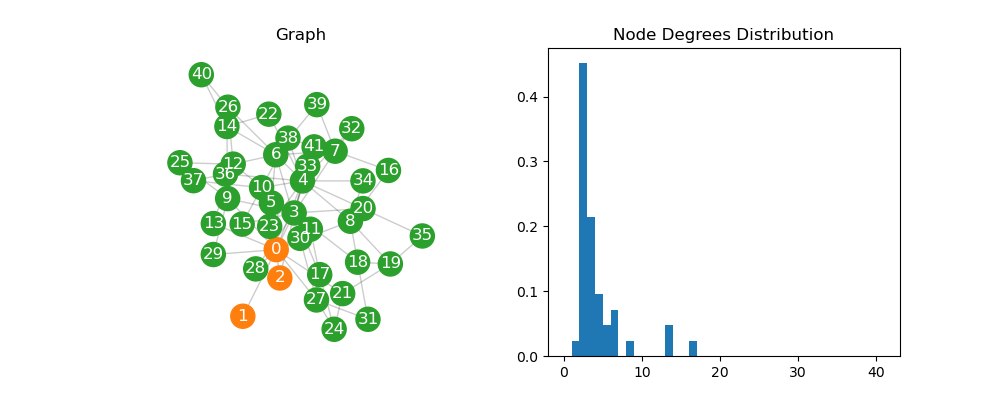

In [7]:
#g = nx.complete_graph(N)
#g = nx.erdos_renyi_graph(N, 0.5, seed=0)
g = nx.barabasi_albert_graph(N, 2, seed=0)
#g = nx.lollipop_graph(N-3, 3)
#g = nx.watts_strogatz_graph(N, 15, 0.5, seed=0)
#g = nx.random_geometric_graph(N, 0.5, seed=42)

# different laysouts
#pos = nx.circular_layout(g)
pos = nx.spring_layout(g)

# for random graph based on euclidian distance, we have to keep the correct positions (not by layout)
# g = nx.random_geometric_graph(N, 0.4, seed=42)
# pos = nx.get_node_attributes(g, 'pos')

# Initialise the types (the nodes for infectious could be chosen at random,
# but as every node is connected to every other node (complete graph) / nodes are connected at random (most random graphs)...
nx.set_node_attributes(g, 0, name='type')
nx.set_node_attributes(g.subgraph(range(Iinit)), 1, name='type')

# alternative way to access the data (nicely printed in rows)
# for node in g.nodes(data=True):
#     print(node)

figGraph = plt.figure(figsize=(10,4))

plt.subplot(121)
nodes = nx.draw_networkx_nodes(g, pos, node_color=[typeColors[attr['type']] for node, attr in g.nodes(data=True)])
labels = nx.draw_networkx_labels(g, pos, font_color='white')
edges = nx.draw_networkx_edges(g, pos, alpha = 0.2)
plt.axis('equal')
plt.axis('off')
plt.title('Graph')


plt.subplot(122)
plt.hist(dict(g.degree()).values(), range(N),rwidth=1, density=True)
plt.title('Node Degrees Distribution')

plt.show()

In [8]:
gOut, t, S, I, R, D, noTy, tG, SG, IG, RG, DG = GillespieGraph(
    T, N, g.copy(), seed, updatePropensities, updateStates, updatePropensitiesG, updateStatesG, iota=iota, rho=rho, delta=delta
)

Up to this point the code was provided, the rest is mine and gives us the final results of the graph Gillespie algorithm for different graph topologies.

In [9]:
# Function to store final values
def storeFinalValues(S, I, R, D):
    final_values = {
        'Susceptible': S[-1],
        'Infected': I[-1],
        'Recovered': R[-1],
        'Deceased': D[-1]
    }
    return final_values

graph_types = [
    nx.complete_graph(N),
    nx.erdos_renyi_graph(N, 0.5, seed=0),
    nx.barabasi_albert_graph(N, 2, seed=0),
    nx.lollipop_graph(N-3, 3),
    nx.watts_strogatz_graph(N, 15, 0.5, seed=0),
    nx.random_geometric_graph(N, 0.5, seed=42)
]

graph_type_names = ['Complete', 'Erdos-Renyi', 'Barabasi-Albert', 'Lollipop', 'Watts-Strogatz', 'Random Geometric']

# Iterate through different graph types
for idx, g_type in enumerate(graph_types):
    g = g_type.copy()
    
    # Initialize node attributes and set initial infected nodes
    nx.set_node_attributes(g, 0, name='type')
    nx.set_node_attributes(g.subgraph(range(Iinit)), 1, name='type')

    # Simulate Gillespie algorithm for each graph type
    gOut, t, S, I, R, D, noTy, tG, SG, IG, RG, DG = GillespieGraph(
        T, N, g, seed, updatePropensities, updateStates, updatePropensitiesG, updateStatesG, iota=iota, rho=rho, delta=delta
    )
    
    # Print final values for each graph type
    final_values = storeFinalValues(S, I, R, D)
    print(f"Final values for {graph_type_names[idx]} graph:")
    for key, value in final_values.items():
        print(f"{key}: {value}")
    print("------------------------")

Final values for Complete graph:
Susceptible: 0
Infected: 0
Recovered: 30
Deceased: 12
------------------------
Final values for Erdos-Renyi graph:
Susceptible: 4
Infected: 0
Recovered: 31
Deceased: 7
------------------------
Final values for Barabasi-Albert graph:
Susceptible: 39
Infected: 0
Recovered: 3
Deceased: 0
------------------------
Final values for Lollipop graph:
Susceptible: 2
Infected: 0
Recovered: 28
Deceased: 12
------------------------
Final values for Watts-Strogatz graph:
Susceptible: 34
Infected: 0
Recovered: 6
Deceased: 2
------------------------
Final values for Random Geometric graph:
Susceptible: 6
Infected: 0
Recovered: 30
Deceased: 6
------------------------


The results for the final values of the Graph Gillespie Algorithm are very different depending on the graph topology. For example for the Barabasi-Albert and Watts-Strogratz graphs, they both have high values for susceptible people, whereas the rest have high values of recovered people. The Lollipop and Complete Graphs also have higher numbers of deceased than the rest.  

Its is clear there is a link between how much the disease spreads and the average node. Using the visualition in figure 1 and using the '#' to comment out the desired graph type, we can see the node degrees distribution. The complete graph naturally has the highest average node degree number and by the fact it has a low number of susceptible people and high number of recovered and deceased, we can see that the high node degree ensures the disease passes through everybody. The opposite can be said for the Barabasi-Albert graph which has a low average node degree and has the highest number of susceptibles left.